In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
from random import uniform
def global_random_search(f, n, bounds, N=1000):
    l = [r[0] for r in bounds]
    u = [r[1] for r in bounds]
    best_params = None
    min_cost = float("inf")
    xs, fs = [], []
    iteration = 0
    for _ in range(N):
        sample = [uniform(l[i], u[i]) for i in range(n)]
        cost = f(*sample)
        if cost < min_cost:
            min_cost = cost
            best_params = sample[:]
        xs.append(best_params[:])
        fs.append(min_cost)
        print(iteration, best_params[:], min_cost)
        iteration += 1
    return xs, fs


In [7]:
from random import uniform

def global_random_search_population(f, n, x_rng, N, M, num_iters, neighbourhood_ratio=0.1):
    # sort_lists function is same as before
    sort_lists = lambda l0, l1: map(list, zip(*sorted(zip(l0, l1))))
    
    # initialize lower and upper bounds
    l = [r[0] for r in x_rng]
    u = [r[1] for r in x_rng]
    
    # initialize best point and value
    best_x = None
    best_f = float('inf')
    
    # track points and values for plotting
    xs, fs = [], []
    
    # generate initial set of N points
    this_xs = [[uniform(l[i], u[i]) for i in range(n)] for _ in range(N)]
    this_fs = [f(*x) for x in this_xs]
    
    # update best point and value
    for i in range(N):
        if this_fs[i] < best_f:
            best_x = this_xs[i][:]
            best_f = this_fs[i]
        xs.append(best_x[:])
        fs.append(best_f)
    
    # determine how many points to replace for each good one
    num_new = (N - M) // M
    
    for _ in range(num_iters):
        # sort set of points with best at front
        this_fs, this_xs = sort_lists(this_fs, this_xs)
        
        for i in range(M):
            this_x = this_xs[i][:]
            for j in range(num_new):
                # perturb each value in the current point by a random amount between (1-neighbourhood_ratio) and (1+neighbourhood_ratio)
                pert_x = [this_x[k] * uniform(1-neighbourhood_ratio, 1+neighbourhood_ratio) if l[k] != u[k] else this_x[k] for k in range(n)]
                k = M + (i * num_new) + j
                this_xs[k] = pert_x[:]
                this_fs[k] = f(*pert_x)
                if this_fs[k] < best_f:
                    best_x = pert_x[:]
                    best_f = this_fs[k]
                xs.append(best_x[:])
                fs.append(best_f)
    
    return xs, fs

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from random import uniform
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

def ConvNet_Model(batch_size, alpha, beta1, beta2, epochs):

  # Model / data parameters
  num_classes = 10
  input_shape = (32, 32, 3)
  batch_size = int(batch_size)
  epochs = int(epochs)

  # the data, split between train and test sets
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  n=1000
  x_train = x_train[1:n]; y_train=y_train[1:n]
  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  model = keras.Sequential()
  model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:],activation='relu'))
  model.add(Conv2D(16, (3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l1(0.0001)))
  optimizer = Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
  y_preds = model.predict(x_test)
  loss = CategoricalCrossentropy()
  return loss(y_test, y_preds).numpy()

In [14]:
def plot_results(gsr_xs, gsr_fs, gsp_xs, gsp_fs, title):
    gsr_N, gsp_N = len(gsr_fs), len(gsp_fs)
    gsr_X, gsp_X = list(range(gsr_N)), list(range(gsp_N))
    plt.figure(figsize=(8, 6))
    plt.plot(gsr_X, gsr_fs, label='Global Random Search')
    plt.plot(gsp_X, gsp_fs, label='Global Population-based Random Search')
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Loss values')
    plt.legend()
    plt.show()

Global Random Search
313/313 [==============================] - 2s 6ms/step
0 [33.19680968425769, 0.001, 0.9, 0.999, 10.0] 1.8302027
313/313 [==============================] - 2s 6ms/step
1 [33.19680968425769, 0.001, 0.9, 0.999, 10.0] 1.8302027
313/313 [==============================] - 2s 6ms/step
2 [108.15310392559725, 0.001, 0.9, 0.999, 10.0] 1.8262717
313/313 [==============================] - 2s 6ms/step
3 [73.04613040542068, 0.001, 0.9, 0.999, 10.0] 1.7885779
313/313 [==============================] - 2s 6ms/step
4 [73.04613040542068, 0.001, 0.9, 0.999, 10.0] 1.7885779
313/313 [==============================] - 2s 6ms/step
5 [73.04613040542068, 0.001, 0.9, 0.999, 10.0] 1.7885779
313/313 [==============================] - 2s 6ms/step
6 [73.04613040542068, 0.001, 0.9, 0.999, 10.0] 1.7885779
313/313 [==============================] - 2s 6ms/step
7 [8.1011129953087, 0.001, 0.9, 0.999, 10.0] 1.7831392
313/313 [==============================] - 2s 6ms/step
8 [8.1011129953087, 0.001, 0.

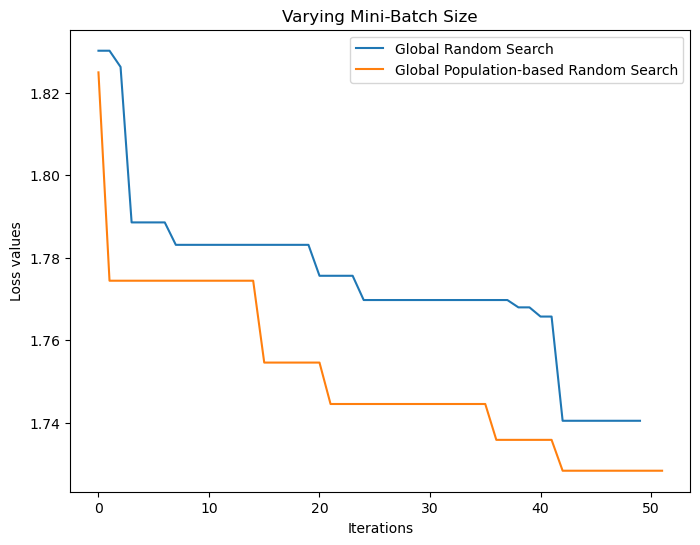

In [15]:
n = 5
xrange = [
    [1, 200],
    [0.001, 0.001],
    [0.9, 0.9],
    [0.999, 0.999],
    [10, 10]
]
print('Global Random Search')
GRS_xs, GRS_fs = global_random_search(ConvNet_Model, n, xrange, N=50)
print('Global Population-based Search')
GRSP_xs, GRSP_fs = global_random_search_population(ConvNet_Model, n, xrange, N=12, M=4, num_iters=5)
plot_results(GRS_xs, GRS_fs, GRSP_xs, GRSP_fs, "Varying Mini-Batch Size")

Global Random Search
313/313 [==============================] - 2s 7ms/step
0 [45.0, 0.025745026850861177, 0.8995603461292113, 0.9979857078376796, 10.0] 2.306788
313/313 [==============================] - 2s 7ms/step
1 [45.0, 0.007451261130518638, 0.8490243240399242, 0.99974969419522, 10.0] 2.305809
313/313 [==============================] - 2s 7ms/step
2 [45.0, 0.007451261130518638, 0.8490243240399242, 0.99974969419522, 10.0] 2.305809
313/313 [==============================] - 2s 7ms/step
3 [45.0, 0.031049800934055474, 0.5948992916825009, 0.947740462163719, 10.0] 2.3056602
313/313 [==============================] - 2s 7ms/step
4 [45.0, 0.031049800934055474, 0.5948992916825009, 0.947740462163719, 10.0] 2.3056602
313/313 [==============================] - 2s 7ms/step
5 [45.0, 0.031049800934055474, 0.5948992916825009, 0.947740462163719, 10.0] 2.3056602
313/313 [==============================] - 2s 7ms/step
6 [45.0, 0.031049800934055474, 0.5948992916825009, 0.947740462163719, 10.0] 2.3056

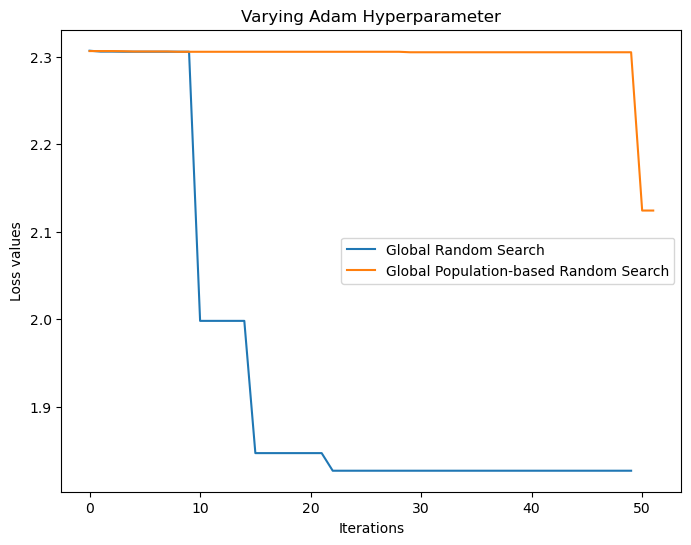

In [18]:
n = 5
x_rng = [[45, 45],
    [0.1, 0.0001],
    [0.25, 0.99],
    [0.9, 0.9999],
    [10, 10]]
print('Global Random Search')
gsr_xs, gsr_fs = global_random_search(ConvNet_Model, n, x_rng, N=50)
print('Global Population-based Search')
gsp_xs, gsp_fs = global_random_search_population(ConvNet_Model, n, x_rng, N=12, M=4, num_iters=5)
plot_results(gsr_xs, gsr_fs, gsp_xs, gsp_fs, "Varying Adam Hyperparameter")

Global Random Search
313/313 [==============================] - 2s 7ms/step
0 [45.0, 0.001, 0.9, 0.999, 12.818451860409645] 1.8171176
313/313 [==============================] - 2s 7ms/step
1 [45.0, 0.001, 0.9, 0.999, 12.818451860409645] 1.8171176
313/313 [==============================] - 2s 7ms/step
2 [45.0, 0.001, 0.9, 0.999, 11.736392420369658] 1.8161559
313/313 [==============================] - 2s 7ms/step
3 [45.0, 0.001, 0.9, 0.999, 11.736392420369658] 1.8161559
313/313 [==============================] - 2s 8ms/step
4 [45.0, 0.001, 0.9, 0.999, 11.736392420369658] 1.8161559
313/313 [==============================] - 2s 7ms/step
5 [45.0, 0.001, 0.9, 0.999, 11.736392420369658] 1.8161559
313/313 [==============================] - 2s 7ms/step
6 [45.0, 0.001, 0.9, 0.999, 11.736392420369658] 1.8161559
313/313 [==============================] - 2s 7ms/step
7 [45.0, 0.001, 0.9, 0.999, 11.736392420369658] 1.8161559
313/313 [==============================] - 2s 7ms/step
8 [45.0, 0.001, 0.9,

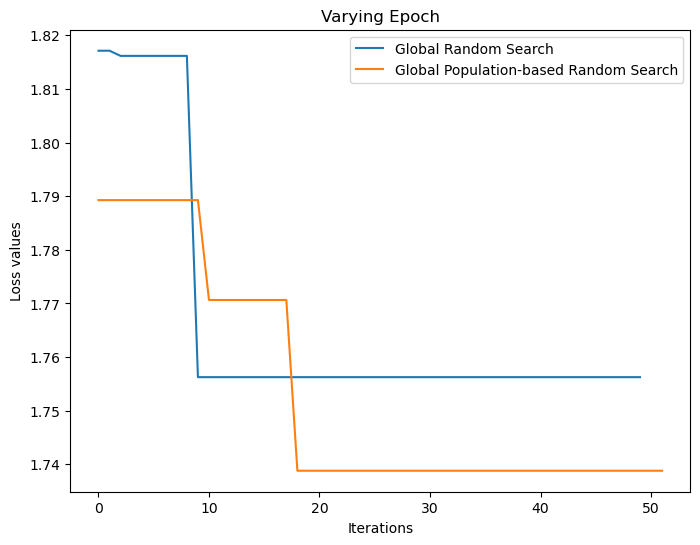

In [19]:
n = 5
x_rng = [
    [45, 45],
    [0.001, 0.001],
    [0.9, 0.9],
    [0.999, 0.999],
    [5, 30]
]
print('Global Random Search')
gsr_xs, gsr_fs = global_random_search(ConvNet_Model, n, x_rng, N=50)
print('Global Population-based Search')
gsp_xs, gsp_fs = global_random_search_population(ConvNet_Model, n, x_rng, N=12, M=4,num_iters=5)
plot_results(gsr_xs, gsr_fs, gsp_xs, gsp_fs, "Varying Epoch")